<a href="https://colab.research.google.com/github/ohumkar/COVID-19/blob/master/New_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Essentials

###### Mounting drive containing image dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###### Setting device to 'CUDA' for faster training

In [0]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Creating Custom DataSet 

###### Because of a mix of single and 3 channel images...all images are converted to RGB format
###### This dataset returns the RGB image along with a one hot label vector 

In [0]:
from torch.utils.data import Dataset
from PIL import Image
import os

class covid(Dataset) :
  def __init__(self, img_dir, transforms, train = True) :
    self.img_dir = img_dir
    self.transforms = transforms
    self.train = train

    self.image_names = []
    for e in os.listdir(self.img_dir) :
      print(e ,end = '\t')
      e = os.path.join(img_dir, e)
      imgs = os.listdir(e)
      imgs = [os.path.join(e,i) for i in imgs]
      self.image_names += imgs
      print(len(self.image_names))    
  
  def __getitem__(self, idx):
    image_name =  self.image_names[idx]
    if 'normal' in image_name :
      label = [1, 0 , 0]
    elif 'pneumonia' in image_name :
      label = [0, 1, 0]
    else :
      label = [0, 0, 1]
    image = Image.open(image_name).convert('RGB')
    #image = image.convert('1')
    
    if self.transforms is not None :
      image = self.transforms(image)
    #print(image.shape)
    # if self.train :
    #   return image, torch.tensor(label)
    # else :
    #   return image
    return image, torch.tensor(label)

  def __len__(self) :
    return len(self.image_names) 

###### Setup up image directories and image dimensions

In [0]:
from torchvision import transforms

image_size = 512
data_train_folder = '/content/drive/My Drive/data/all/train'
data_test_folder = '/content/drive/My Drive/data/all/test'
transformations = transforms.Compose([transforms.Resize((image_size, image_size)),
                                               #transforms.CenterCrop(image_size),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                               #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                               ])

###### Create train and test instances of dataset 

In [0]:
train_dataset = covid(img_dir = data_train_folder, transforms = transformations ,train = True)
test_dataset = covid(img_dir = data_test_folder, transforms = transformations, train = False)

normal	70
covid	130
pneumonia_bac	200
pneumonia_vir	270
covid	9
pneumonia_vir	18
pneumonia_bac	27
normal	36


# Creating Helper Functions

###### Dictionary of Encoded Labels

In [0]:
#Encoding for labels
encoding = {0:'Normal', 1:'Pneumonic', 2:'Covid'}

###### Retrieve encodings from Class Indices

In [0]:
#Function to Retrieve encodings from Class Indices

def get_encoding(y) :
  result = []
  indices = []
  for e in y :
    e = torch.argmax(e).item()
    result.append(encoding[e])
    indices.append(e)
  return indices, result

In [0]:
# def get_encoding(x) :
#   temp = np.array(0)
#   if type(x) != type(temp) :
#     x = np.array(x)
#   print(type(x))
  
#   for e in x :
#     return encoding[e]

# get_encoding(1)

###### Denormalize images for plotting

In [0]:
#Function to Denormalize Normalized Image Tensor

def denorm(x) :
  out = (x*.225 + 0.486)
  return out.clamp(0,1)

###### Display image

In [0]:
#Looking at one image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')


def imgshow(x, y) :
  denorm_x = denorm(x)
  print('Image Shape: ',denorm_x.shape)
  plt.imshow(denorm_x[0], cmap = 'gray')
  plt.title(encoding[torch.max(y).item()])
  plt.show()

<Figure size 800x480 with 0 Axes>

###### Gradient reseting after minibatch iteration

In [0]:
#setting accumulated gradients to zero

def reset_grads() :
  optimizer.zero_grad()

# Viewing the Dataset

In [0]:
#Train Set Stats
print('Length of Dataset :',len(train_dataset))
im, tar = train_dataset[0] #use __getitem__ to get first example
print(type(im), im.shape)
print(type(tar), tar.shape)
print(tar)
print(torch.max(tar).item())

torch.min(im), torch.max(im)

Length of Dataset : 270
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3])
tensor([1, 0, 0])
1


(tensor(-2.1179), tensor(2.6400))

In [0]:
#Test Set Stats
print('Length of Dataset :',len(test_dataset))
im,_ = test_dataset[0] #use __getitem__ to get first example
print(type(im), im.shape)

torch.min(im), torch.max(im)

Length of Dataset : 36
<class 'torch.Tensor'> torch.Size([3, 512, 512])


(tensor(-2.1179), tensor(2.5529))

# Creating Train and Test Dataset Loaders

In [0]:
#Loader parameters
batch_size = 4
workers = 4

#Creating DataLoader
from torch.utils.data import DataLoader #returns batch of img and label

train_data_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory = True)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory = True)

Size of Image Batch: 4
Shape of Image Batch: torch.Size([4, 3, 512, 512])
Shape of Label Batch: torch.Size([4, 3])
Image Shape:  torch.Size([3, 512, 512])


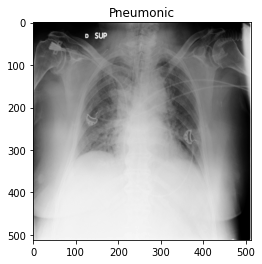

In [0]:
#View a sample from train data loader

for idx, (img_batch, label_batch) in enumerate(train_data_loader) :
  print('Size of Image Batch:', len(img_batch))    #img_batch dimensions ==>  [batch_size, channel, height, width]
  print('Shape of Image Batch:', img_batch.shape)
  print('Shape of Label Batch:', label_batch.shape) #label batch shape 
  imgshow(img_batch[0], label_batch[0])
  break

Size of Image Batch: 4
Shape of Image Batch: torch.Size([4, 3, 512, 512])
Image Shape:  torch.Size([3, 512, 512])


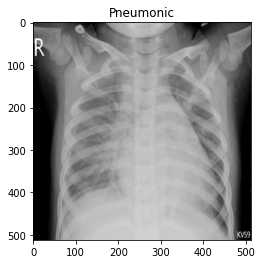

In [0]:
#View a sample from test data loader

for idx, (img_batch, label_batch) in enumerate(test_data_loader) :
  print('Size of Image Batch:', len(img_batch))    #img_batch dimensions ==>  [batch_size, channel, height, width]
  print('Shape of Image Batch:', img_batch.shape)
  #print('Shape of Label Batch:', label_batch.shape)
  imgshow(img_batch[0], label_batch[0])
  break

# Getting our Neural Network

###### Here we use a pretrained model of Resnet50 which we further fine tune


In [0]:
import torchvision.models as models
import torch.nn as nn

resnet50 = models.resnet50(pretrained=True)

In [0]:
#Freezing parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [0]:
#Modifying last Fully Connected Layer to output 3 values
resnet50.fc = nn.Linear(2048 ,3)

In [0]:
# import torch.nn as nn
# import torch.nn.functional as F

# class add_model(nn.Module) :
#   def __init__(self) :
#     super(add_model, self).__init__()
#     self.fc1 = nn.Linear(1000, 128, bias = True)
#     self.fc2 = nn.Linear(128, 3, bias = True) 
  
#   def forward(self, x) :
#     z = F.relu(self.fc1(x))
#     z = self.fc2(z)

#     return z

In [0]:
# addition = add_model()
# #addition.eval()

In [0]:
# #num_ftrs = resnet.fc.in_features
# model = nn.Sequential(resnet50, addition)
# model.to(device)
# model.eval()

# Defining Loss Criterion and Optimizer

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

summed = 70 + 60 + 140
weight = torch.tensor([summed / 70, summed / 60, summed / 140])
learning_rate = 0.001
criterion = nn.CrossEntropyLoss(weight = weight.to(device))
optimizer = optim.Adam(resnet50.parameters(), lr = learning_rate)

In [0]:
#Move model to device and set it in evaluate mode

resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training the Model

In [0]:
max_epochs = 70
total_step = len(train_data_loader)
losses = []

for epoch in range(max_epochs) :
  for i, (image_batch, label_batch) in enumerate(train_data_loader) :
    #Get predictions
    outputs = resnet50(image_batch.to(device))
    #outputs = torch.max(outputs, 1)[1]
    labels = torch.max(label_batch, 1)[1]
    # print(outputs.shape)
    # print(labels.shape)

    #Calculate Loss
    loss = criterion(outputs, labels.to(device))

    #Clear previous gradients
    reset_grads()

    #Compute gradients of loss functions wrt paramters
    loss.backward()

    #Carry one step of backpropagation
    optimizer.step()

    # Inspect the losses
    if (i+1) % 17 == 0:
      losses.append(loss.item())
      print('Epoch [ {} / {} ], Step [ {} / {} ], Loss: {:.4f}, '.format(epoch, max_epochs, i+1, total_step, loss.item()))
  torch.save(resnet50.state_dict(), 'Resnet50-epoch:{}.ckpt'.format(i + 1))
  print('Model Saved!')
        # if losses[-1] < losses[-2] :
        #   torch.save(model.state_dict(), 'Resnet50-epoch:{}.ckpt'.format(i + 1))
        #   print('Model Saved!')

Epoch [ 0 / 70 ], Step [ 17 / 68 ], Loss: 0.6932, 
Epoch [ 0 / 70 ], Step [ 34 / 68 ], Loss: 0.4863, 
Epoch [ 0 / 70 ], Step [ 51 / 68 ], Loss: 0.4615, 
Epoch [ 0 / 70 ], Step [ 68 / 68 ], Loss: 1.0234, 
Model Saved!
Epoch [ 1 / 70 ], Step [ 17 / 68 ], Loss: 0.0839, 
Epoch [ 1 / 70 ], Step [ 34 / 68 ], Loss: 0.2499, 
Epoch [ 1 / 70 ], Step [ 51 / 68 ], Loss: 1.2009, 
Epoch [ 1 / 70 ], Step [ 68 / 68 ], Loss: 0.0610, 
Model Saved!
Epoch [ 2 / 70 ], Step [ 17 / 68 ], Loss: 0.0660, 
Epoch [ 2 / 70 ], Step [ 34 / 68 ], Loss: 0.1339, 
Epoch [ 2 / 70 ], Step [ 51 / 68 ], Loss: 0.7243, 
Epoch [ 2 / 70 ], Step [ 68 / 68 ], Loss: 0.0467, 
Model Saved!
Epoch [ 3 / 70 ], Step [ 17 / 68 ], Loss: 0.1268, 
Epoch [ 3 / 70 ], Step [ 34 / 68 ], Loss: 0.1024, 
Epoch [ 3 / 70 ], Step [ 51 / 68 ], Loss: 0.3935, 
Epoch [ 3 / 70 ], Step [ 68 / 68 ], Loss: 0.1418, 
Model Saved!
Epoch [ 4 / 70 ], Step [ 17 / 68 ], Loss: 0.1963, 
Epoch [ 4 / 70 ], Step [ 34 / 68 ], Loss: 0.2497, 
Epoch [ 4 / 70 ], Step [ 51 / 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Epoch [ 65 / 70 ], Step [ 17 / 68 ], Loss: 0.0156, 
Epoch [ 65 / 70 ], Step [ 34 / 68 ], Loss: 0.0308, 
Epoch [ 65 / 70 ], Step [ 51 / 68 ], Loss: 0.0128, 
Epoch [ 65 / 70 ], Step [ 68 / 68 ], Loss: 0.0002, 
Model Saved!
Epoch [ 66 / 70 ], Step [ 17 / 68 ], Loss: 0.0039, 
Epoch [ 66 / 70 ], Step [ 34 / 68 ], Loss: 0.0181, 
Epoch [ 66 / 70 ], Step [ 51 / 68 ], Loss: 0.0063, 
Epoch [ 66 / 70 ], Step [ 68 / 68 ], Loss: 0.0034, 
Model Saved!
Epoch [ 67 / 70 ], Step [ 17 / 68 ], Loss: 0.0353, 
Epoch [ 67 / 70 ], Step [ 34 / 68 ], Loss: 0.0446, 
Epoch [ 67 / 70 ], Step [ 51 / 68 ], Loss: 0.0210, 
Epoch [ 67 / 70 ], Step [ 68 / 68 ], Loss: 0.0003, 
Model Saved!
Epoch [ 68 / 70 ], Step [ 17 / 68 ], Loss: 0.0088, 
Epoch [ 68 / 70 ], Step [ 34 / 68 ], Loss: 0.0017, 
Epoch [ 68 / 70 ], Step [ 51 / 68 ], Loss: 0.0134, 
Epoch [ 68 / 70 ], Step [ 68 / 68 ], Loss: 0.0339, 
Model Saved!
Epoch [ 69 / 70 ], Step [ 17 / 68 ], Loss: 0.0152, 
Epoch [ 69 / 70 ], Step [ 34 / 68 ], Loss: 0.0034, 
Epoch [ 69 /

# Result analysis

###### Plotting Loss Function

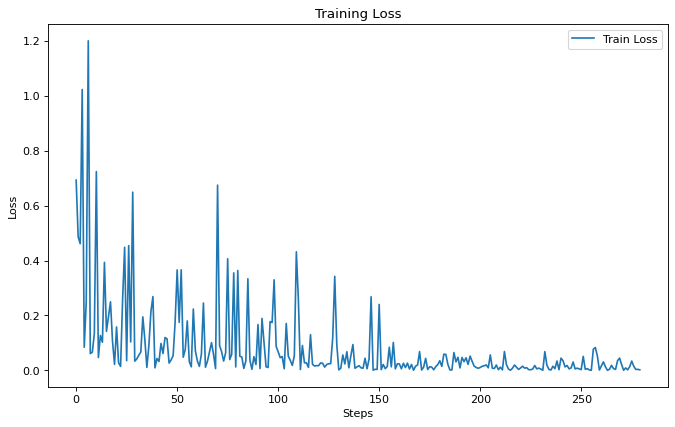

In [0]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(losses, label = 'Train Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

###### Getting model predictions on test dataset

In [0]:
test_targets = []
test_predictions = []
for idx, (test_img, test_label) in enumerate(test_data_loader) :
  print('Batch [ {} / {} ] '.format(idx, len(test_data_loader)))
  ground_indices, ground_truth = get_encoding(test_label)
  predictions = resnet50(test_img.to(device))
  pred_indices, predictions = get_encoding(predictions)
  test_targets.extend(ground_indices)
  test_predictions.extend(pred_indices)

  print('Truth :      {}\nPredictions :{}'.format(ground_truth, predictions))
  print('-----------------------------------------------')

Batch [ 0 / 9 ] 
Truth :      ['Pneumonic', 'Pneumonic', 'Covid', 'Normal']
Predictions :['Pneumonic', 'Pneumonic', 'Covid', 'Normal']
-----------------------------------------------
Batch [ 1 / 9 ] 
Truth :      ['Pneumonic', 'Pneumonic', 'Pneumonic', 'Normal']
Predictions :['Pneumonic', 'Pneumonic', 'Pneumonic', 'Normal']
-----------------------------------------------
Batch [ 2 / 9 ] 
Truth :      ['Covid', 'Covid', 'Pneumonic', 'Normal']
Predictions :['Covid', 'Pneumonic', 'Pneumonic', 'Normal']
-----------------------------------------------
Batch [ 3 / 9 ] 
Truth :      ['Pneumonic', 'Normal', 'Pneumonic', 'Covid']
Predictions :['Pneumonic', 'Pneumonic', 'Pneumonic', 'Covid']
-----------------------------------------------
Batch [ 4 / 9 ] 
Truth :      ['Normal', 'Pneumonic', 'Pneumonic', 'Normal']
Predictions :['Normal', 'Normal', 'Pneumonic', 'Normal']
-----------------------------------------------
Batch [ 5 / 9 ] 
Truth :      ['Pneumonic', 'Pneumonic', 'Pneumonic', 'Normal']

In [0]:
import pandas as pd
summary = {'Test Targets':test_targets, 'Test Predictions':test_predictions}
summary = pd.DataFrame(summary)

In [0]:
summary.head()

,Test Targets,Test Predictions
0,1,1
1,1,1
2,2,2
3,0,0
4,1,1


###### Plotting confusion matrix
###### Class 0 : Normal '' Class 1 : Pneumonia       Class 2 : COVID

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


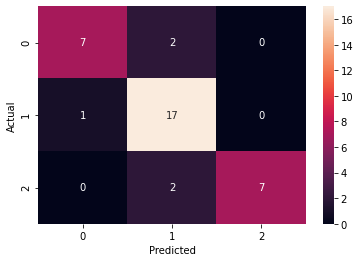

In [0]:
import seaborn as sn
confusion_matrix = pd.crosstab(summary['Test Targets'], summary['Test Predictions'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()